In [1]:
# Install dependencies
!pip install diffusers transformers accelerate safetensors --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.2 MB/s eta 0:00:00


In [2]:
# Import libraries
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [17]:
# Load Diffuser of choice -- baseline model (SD 1.5)
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
).to("cuda")

tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
unet = pipe.unet
vae = pipe.vae
scheduler = pipe.scheduler

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [24]:
# Initialize Prompt Input
prompt = "a high-resolution photograph of a duck sitting on the beach, close-up, ultra-realistic, 4k, sharp focus, natural lighting"
max_length = tokenizer.model_max_length
guidance_scale = 8.5
timesteps = 75

# Tokenize prompt (CLIP)
text_input = tokenizer([prompt], padding="max_length", max_length=max_length, return_tensors="pt").to("cuda")
uncond_input = tokenizer([""], padding="max_length", max_length=max_length, return_tensors="pt").to("cuda")

# Get text embeddings (CLIP)
with torch.no_grad():
    text_embeddings = text_encoder(**text_input).last_hidden_state.half()
    uncond_embeddings = text_encoder(**uncond_input).last_hidden_state.half()

context_embeddings = torch.cat([uncond_embeddings, text_embeddings], dim=0)


In [25]:
# Initialize Latent of pure noise
latents = torch.randn((1, unet.in_channels, 64, 64)).to("cuda").half()
scheduler.set_timesteps(timesteps)

# Denoise using U-Net (given embedding and pure noise latent)
for t in tqdm(scheduler.timesteps, desc="Denoising"):
    latent_input = torch.cat([latents] * 2)
    latent_input = scheduler.scale_model_input(latent_input, t)

    with torch.no_grad():
        noise_pred = unet(latent_input, t, encoder_hidden_states=context_embeddings).sample

    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    guided_noise = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    latents = scheduler.step(guided_noise, t, latents).prev_sample


<ipython-input-25-f942638530bc>:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((1, unet.in_channels, 64, 64)).to("cuda").half()
Denoising: 100%|██████████| 76/76 [00:12<00:00,  6.32it/s]


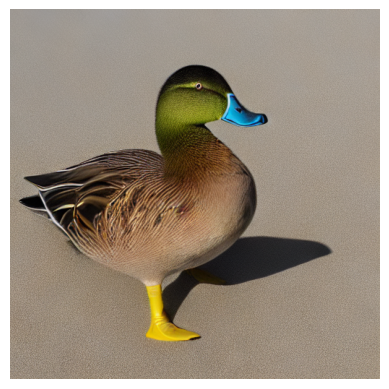

In [26]:
# Decode the denoised latent into a full size RGB image (VAE decoder)
with torch.no_grad():
    latents = 1 / 0.18215 * latents
    decoded = vae.decode(latents).sample

image = (decoded / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
image = (image * 255).astype("uint8")
image = Image.fromarray(image)

# Display image
plt.imshow(image)
plt.axis("off")
plt.show()